<a href="https://colab.research.google.com/github/FalseFeint/MertsMinions/blob/main/MRI_Segmentation_Original.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mounting Drive & Git

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd ~/../content/drive/My\ Drive/ML\ Final\ Project/MertsMinions

Mounted at /content/drive
/content/drive/My Drive/ML Final Project/MertsMinions


In [2]:
! git pull

Already up to date.


# Imports

In [3]:
import os
import random

from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from tqdm import tqdm
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
from skimage.transform import resize, rescale, rotate
from torch.utils.data import Dataset
from torchvision.transforms import Compose
import matplotlib
from matplotlib import pyplot as plt

# Preprocess

In [4]:
def crop_sample(x):
    volume, mask = x
    volume[volume < np.max(volume) * 0.1] = 0
    z_projection = np.max(np.max(np.max(volume, axis=-1), axis=-1), axis=-1)
    z_nonzero = np.nonzero(z_projection)
    z_min = np.min(z_nonzero)
    z_max = np.max(z_nonzero) + 1
    y_projection = np.max(np.max(np.max(volume, axis=0), axis=-1), axis=-1)
    y_nonzero = np.nonzero(y_projection)
    y_min = np.min(y_nonzero)
    y_max = np.max(y_nonzero) + 1
    x_projection = np.max(np.max(np.max(volume, axis=0), axis=0), axis=-1)
    x_nonzero = np.nonzero(x_projection)
    x_min = np.min(x_nonzero)
    x_max = np.max(x_nonzero) + 1
    return (
        volume[z_min:z_max, y_min:y_max, x_min:x_max],
        mask[z_min:z_max, y_min:y_max, x_min:x_max],
    )


def pad_sample(x):
    volume, mask = x
    a = volume.shape[1]
    b = volume.shape[2]
    if a == b:
        return volume, mask
    diff = (max(a, b) - min(a, b)) / 2.0
    if a > b:
        padding = ((0, 0), (0, 0), (int(np.floor(diff)), int(np.ceil(diff))))
    else:
        padding = ((0, 0), (int(np.floor(diff)), int(np.ceil(diff))), (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)
    return volume, mask


def resize_sample(x, size=256):
    volume, mask = x
    v_shape = volume.shape
    out_shape = (v_shape[0], size, size)
    mask = resize(
        mask,
        output_shape=out_shape,
        order=0,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    out_shape = out_shape + (v_shape[3],)
    volume = resize(
        volume,
        output_shape=out_shape,
        order=2,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    )
    return volume, mask


def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99))
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume

# Data Augmentation

In [5]:
def transforms(scale=None, angle=None, flip_prob=None):
    transform_list = []

    if scale is not None:
        transform_list.append(Scale(scale))
    if angle is not None:
        transform_list.append(Rotate(angle))
    if flip_prob is not None:
        transform_list.append(HorizontalFlip(flip_prob))

    return Compose(transform_list)


class Scale(object):

    def __init__(self, scale):
        self.scale = scale

    def __call__(self, sample):
        image, mask = sample

        img_size = image.shape[0]

        scale = np.random.uniform(low=1.0 - self.scale, high=1.0 + self.scale)

        image = rescale(
            image,
            (scale, scale),
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )
        mask = rescale(
            mask,
            (scale, scale),
            order=0,
            multichannel=True,
            preserve_range=True,
            mode="constant",
            anti_aliasing=False,
        )

        if scale < 1.0:
            diff = (img_size - image.shape[0]) / 2.0
            padding = ((int(np.floor(diff)), int(np.ceil(diff))),) * 2 + ((0, 0),)
            image = np.pad(image, padding, mode="constant", constant_values=0)
            mask = np.pad(mask, padding, mode="constant", constant_values=0)
        else:
            x_min = (image.shape[0] - img_size) // 2
            x_max = x_min + img_size
            image = image[x_min:x_max, x_min:x_max, ...]
            mask = mask[x_min:x_max, x_min:x_max, ...]

        return image, mask


class Rotate(object):

    def __init__(self, angle):
        self.angle = angle

    def __call__(self, sample):
        image, mask = sample

        angle = np.random.uniform(low=-self.angle, high=self.angle)
        image = rotate(image, angle, resize=False, preserve_range=True, mode="constant")
        mask = rotate(
            mask, angle, resize=False, order=0, preserve_range=True, mode="constant"
        )
        return image, mask


class HorizontalFlip(object):

    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, sample):
        image, mask = sample

        if np.random.rand() > self.flip_prob:
            return image, mask

        image = np.fliplr(image).copy()
        mask = np.fliplr(mask).copy()

        return image, mask

#UNet
Create UNet architecture

In [19]:

class UNet(nn.Module):

  def __init__(self, in_channels=3, out_channels=1, init_features=32):
      super(UNet, self).__init__()

      features = init_features
      self.encoder1 = UNet._block(in_channels, features, name="enc1")
      self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.encoder2 = UNet._block(features, features * 2, name="enc2")
      self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
      self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
      self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
      self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

      self.upconv4 = nn.ConvTranspose2d(
          features * 16, features * 8, kernel_size=2, stride=2
      )
      self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
      self.upconv3 = nn.ConvTranspose2d(
          features * 8, features * 4, kernel_size=2, stride=2
      )
      self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
      self.upconv2 = nn.ConvTranspose2d(
          features * 4, features * 2, kernel_size=2, stride=2
      )
      self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
      self.upconv1 = nn.ConvTranspose2d(
          features * 2, features, kernel_size=2, stride=2
      )
      self.decoder1 = UNet._block(features * 2, features, name="dec1")

      self.conv = nn.Conv2d(
          in_channels=features, out_channels=out_channels, kernel_size=1
      )

  def forward(self, x):
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      dec4 = self.upconv4(bottleneck)
      dec4 = torch.cat((dec4, enc4), dim=1)
      dec4 = self.decoder4(dec4)
      dec3 = self.upconv3(dec4)
      dec3 = torch.cat((dec3, enc3), dim=1)
      dec3 = self.decoder3(dec3)
      dec2 = self.upconv2(dec3)
      dec2 = torch.cat((dec2, enc2), dim=1)
      dec2 = self.decoder2(dec2)
      dec1 = self.upconv1(dec2)
      dec1 = torch.cat((dec1, enc1), dim=1)
      dec1 = self.decoder1(dec1)
      return torch.sigmoid(self.conv(dec1))

  """" 
  This function is useful for blocking together convolutions, activations, 
  and max pooling for each "meta-layer" in our U-Net architecture 

  Convolution layers in this block have specified in channels, 
  features, a kernel size of 3, padding of 1 and no bias

  We use batch normalization to reduce internal covariance

  ReLU is used for non-linearity activation
  """
  @staticmethod
  def _block(in_channels, features, name):
      return nn.Sequential(
          OrderedDict(
              [
                  (
                      name + "conv1",
                      nn.Conv2d(
                          in_channels=in_channels,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm1", nn.BatchNorm2d(num_features=features)),
                  (name + "relu1", nn.ReLU(inplace=True)),
                  (
                      name + "conv2",
                      nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm2", nn.BatchNorm2d(num_features=features)),
                  (name + "relu2", nn.ReLU(inplace=True)),
              ]
          )
      )




In [7]:
UNet = UNet()

# Dice Loss

In [8]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

# Dataset Utilities

In [9]:
def data_loaders(batch_size, workers, image_size, aug_scale, aug_angle):
    dataset_train, dataset_valid = datasets("./dataset", image_size, aug_scale, aug_angle)

    def worker_init(worker_id):
        np.random.seed(42 + worker_id)

    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=workers,
        worker_init_fn=worker_init,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=workers,
        worker_init_fn=worker_init,
    )

    return loader_train, loader_valid


def datasets(images, image_size, aug_scale, aug_angle):
    train = BrainSegmentationDataset(
        images_dir=images,
        subset="train",
        image_size=image_size,
        # transform=transforms(scale=aug_scale, angle=aug_angle, flip_prob=0.5),
        transform=None,

    )
    valid = BrainSegmentationDataset(
        images_dir=images,
        subset="validation",
        image_size=image_size,
        random_sampling=False,
    )
    return train, valid

class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        seed=42,
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            patient_id = "None"
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])
            dictIndex = len(volumes)
            print("Volume: " + str(dictIndex) \
                  + " Patient ID: " + str(patient_id) \
                  + " Images: " + str(len(image_slices)) \
                  + " Masks: " + str(len(mask_slices)))

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=10)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor

# Post Processing 

In [10]:
def log_images(x, y_true, y_pred, channel=1):
    images = []
    x_np = x[:, channel].cpu().numpy()
    y_true_np = y_true[:, 0].cpu().numpy()
    y_pred_np = y_pred[:, 0].cpu().numpy()
    for i in range(x_np.shape[0]):
        image = gray2rgb(np.squeeze(x_np[i]))
        image = outline(image, y_pred_np[i], color=[255, 0, 0])
        image = outline(image, y_true_np[i], color=[0, 255, 0])
        images.append(image)
    return images


def gray2rgb(image):
    w, h = image.shape
    image += np.abs(np.min(image))
    image_max = np.abs(np.max(image))
    if image_max > 0:
        image /= image_max
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 2] = ret[:, :, 1] = ret[:, :, 0] = image * 255
    return ret


def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image

def dsc(y_pred, y_true):
    y_pred = np.round(y_pred).astype(int)
    y_true = np.round(y_true).astype(int)
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))


def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true)
    return dsc_dict


def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes


def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))

def log_scalar_summary(tag, value, step):
    print("epoch {} | {}: {}".format(step + 1, tag, value))


def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

#Training

## Parameters

## Create Dataset

In [14]:
batch_size = 16
epochs = 50
lr = 0.01
workers = 2
weights = "./"
image_size = 224
aug_scale = 0.05
aug_angle = 15

In [15]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

loader_train, loader_valid = data_loaders(batch_size, workers, image_size, aug_scale, aug_angle)
loaders = {"train": loader_train, "valid": loader_valid}

reading train images...
Volume: 0 Patient ID: None Images: 0 Masks: 0
Volume: 1 Patient ID: TCGA_CS_4941_19960909 Images: 23 Masks: 23
Volume: 2 Patient ID: TCGA_CS_4942_19970222 Images: 20 Masks: 20
Volume: 3 Patient ID: TCGA_CS_4943_20000902 Images: 20 Masks: 20
Volume: 4 Patient ID: TCGA_CS_4944_20010208 Images: 20 Masks: 20
Volume: 5 Patient ID: TCGA_CS_5393_19990606 Images: 20 Masks: 20
Volume: 6 Patient ID: TCGA_CS_5395_19981004 Images: 20 Masks: 20
Volume: 7 Patient ID: TCGA_CS_5396_20010302 Images: 24 Masks: 24
Volume: 8 Patient ID: TCGA_CS_5397_20010315 Images: 22 Masks: 22
Volume: 9 Patient ID: TCGA_CS_6186_20000601 Images: 25 Masks: 25
Volume: 10 Patient ID: TCGA_CS_6188_20010812 Images: 24 Masks: 24
Volume: 11 Patient ID: TCGA_CS_6290_20000917 Images: 20 Masks: 20
Volume: 12 Patient ID: TCGA_CS_6665_20010817 Images: 24 Masks: 24
Volume: 13 Patient ID: TCGA_CS_6666_20011109 Images: 26 Masks: 26
Volume: 14 Patient ID: TCGA_CS_6667_20011105 Images: 20 Masks: 20
Volume: 15 Pati

## Create UNet

In [20]:
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Training

In [22]:


# TODO: Use basic loss function in original UNet
dsc_loss = DiceLoss()
# dsc_loss = nn.CrossEntropyLoss();
best_validation_dsc = 0.0

# TODO: Use basic optimizer in original UNet
# optimizer = optim.Adam(unet.parameters(), lr=lr)
optimizer = optim.SGD(unet.parameters(), lr=lr, momentum=0.99)

loss_train = []
loss_valid = []

step = 0

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_dsc_history    = np.zeros(epochs)

for epoch in range(epochs):
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1

            x, y_true = data
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = unet(x)

                loss = dsc_loss(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )
                    
                if phase == "train":
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()

        if phase == "train":
            log_loss_summary(loss_train, epoch)
            train_loss_history[epoch] = np.mean(loss_train)
            loss_train = []

        if phase == "valid":
            log_loss_summary(loss_valid, epoch, prefix="val_")
            val_loss_history[epoch]  = np.mean(loss_valid)
            mean_dsc = np.mean(
                dsc_per_volume(
                    validation_pred,
                    validation_true,
                    loader_valid.dataset.patient_slice_index,
                )
            )
            val_dsc_history[epoch] = mean_dsc
            log_scalar_summary("val_dsc", mean_dsc, epoch)
            if mean_dsc > best_validation_dsc:
                best_validation_dsc = mean_dsc
                torch.save(unet.state_dict(), os.path.join(weights, "unet.pt"))
            loss_valid = []

print("\nBest validation mean DSC: {:4f}\n".format(best_validation_dsc))

state_dict = torch.load(os.path.join(weights, "unet.pt"))
unet.load_state_dict(state_dict)
unet.eval()

input_list = []
pred_list = []
true_list = []

for i, data in enumerate(loader_valid):
    x, y_true = data
    x, y_true = x.to(device), y_true.to(device)
    with torch.set_grad_enabled(False):
        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])
        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])
        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])
        
volumes = postprocess_per_volume(
    input_list,
    pred_list,
    true_list,
    loader_valid.dataset.patient_slice_index,
    loader_valid.dataset.patients,
)

dsc_dist = dsc_distribution(volumes)

dsc_dist_plot = plot_dsc(dsc_dist)
imsave("./dsc.png", dsc_dist_plot)

for p in volumes:
    x = volumes[p][0]
    y_pred = volumes[p][1]
    y_true = volumes[p][2]
    for s in range(x.shape[0]):
        image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
        image = outline(image, y_pred[s, 0], color=[255, 0, 0])
        image = outline(image, y_true[s, 0], color=[0, 255, 0])
        filename = "{}-{}.png".format(p, str(s).zfill(2))
        filepath = os.path.join("./", filename)
        imsave(filepath, image)

epoch 1 | loss: 0.24489611645157522
epoch 1 | val_loss: 0.46301086743672687
epoch 1 | val_dsc: 0.6950631535296002
epoch 2 | loss: 0.2123926984002957
epoch 2 | val_loss: 0.4927329279127575
epoch 2 | val_dsc: 0.6513960318341911
epoch 3 | loss: 0.1771925722177212
epoch 3 | val_loss: 0.41406924383980886
epoch 3 | val_dsc: 0.7338804736867633
epoch 4 | loss: 0.15504412353038788
epoch 4 | val_loss: 0.3846552599044073
epoch 4 | val_dsc: 0.7384072622949732
epoch 5 | loss: 0.14036754833964202
epoch 5 | val_loss: 0.40198575315021334
epoch 5 | val_dsc: 0.7397325070863368
epoch 6 | loss: 0.12938796585569015
epoch 6 | val_loss: 0.40215444280987694
epoch 6 | val_dsc: 0.7583709312171146
epoch 7 | loss: 0.11948851066140029
epoch 7 | val_loss: 0.40794528949828374
epoch 7 | val_dsc: 0.7731642868342744
epoch 8 | loss: 0.1183208439212579
epoch 8 | val_loss: 0.37453071560178486
epoch 8 | val_dsc: 0.7856003695406268
epoch 9 | loss: 0.10757003638606805
epoch 9 | val_loss: 0.3224774230094183
epoch 9 | val_dsc:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_7014_19860618-57.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_6408_19860521-51.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_6408_19860521-52.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_6408_19860521-53.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_6404_19850629-50.png is a low contrast image
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:129: UserWarning: ./TCGA_DU_5851_19950428-34.png is a low contrast im

In [23]:
print(val_loss_history)

[0.46301087 0.49273293 0.41406924 0.38465526 0.40198575 0.40215444
 0.40794529 0.37453072 0.32247742 0.36977375 0.36129225 0.31342933
 0.34179852 0.35277224 0.36126904 0.36203202 0.27019416 0.34395935
 0.34422048 0.34927062 0.34670479 0.33195977 0.34721713 0.35024957
 0.30754196 0.29613561 0.34961559 0.3575538  0.31170238 0.27148818
 0.3297789  0.29699926 0.35667488 0.31667597 0.30345577 0.34085174
 0.30491097 0.30254464 0.32103106 0.35728822 0.30219554 0.30487306
 0.30443681 0.35340749 0.3453556  0.32465476 0.29861341 0.31273924
 0.35738261 0.30833511]


# Plot Results

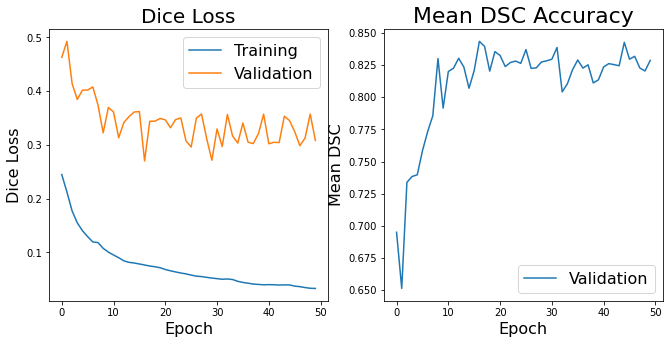

In [24]:
# Plot loss
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Dice Loss", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Dice Loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Mean DSC Accuracy", fontsize=22)
ax.plot(val_dsc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Mean DSC",     fontsize=16)
ax.legend(loc="best",         fontsize=16)